<a href="https://colab.research.google.com/github/muhammadaasem/rm_assignment/blob/master/DNN_T1_R2_DNN_modeling_for_quantization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Implementing Quantization
by Muhammad Aasem

file: DNN_T1_R1-DNN_modeling_for_quantization  
# DNN Model
steps:

1.   import libraries
2.   populate transet and testset from mnist dataset and normalize them
3.   create the *model* with few layers
4.   compile the model
5.   evaluate the model with testset
6.   check summary for parameters
7.   save the model


In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals

import tensorflow as tf
from tensorflow import keras

print ("Tensorflow version:"+tf.__version__)

def load_data():
  print ("\nLoading Dataset:")
  (x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()
  print ("\ttrain-set:"+str(x_train.shape))
  print ("\ttest-set:"+str(x_test.shape))

  x_train = x_train.astype('float32')
  x_test = x_test.astype('float32')
  print ("\ttrain and test sets astype: "+'float32')

  x_train, x_test = x_train / 255.0, x_test / 255.0
  print ("\ttrain and test sets normalized: 255.0")
  return (x_train, y_train), (x_test, y_test)

(x_train, y_train), (x_test, y_test) =load_data()

def create_model():
  print ("model defined")
  model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=(28, 28)),
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(10, activation='softmax')
  ])

  print ("model compiled")
  model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
  return model

model=create_model()

print ("\ncheckpoint defined")
model_checkpoint=tf.keras.callbacks.ModelCheckpoint('MNIST{epoch:02d}.h5',save_freq=3,save_weights_only=True)

print ("\nmodel training...")
history = model.fit(x_train, y_train, epochs=5 )

print ("\nModel Evaluation:")
model.evaluate(x_test,  y_test, verbose=2)

print ("\nModel Summary:")
model.summary()

print ("\nSaving the model")
model.save(filepath="model.h5")
model.save_weights(filepath="model_weights.h5")
with open("model.json", "w") as json_file:
    json_file.write(model.to_json())

Tensorflow version:1.15.0

Loading Dataset:
11493376/11490434 [==============================] - 0s 0us/step
	train-set:(60000, 28, 28)
	test-set:(10000, 28, 28)
	train and test sets astype: float32
	train and test sets normalized: 255.0
model defined
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
model compiled

checkpoint defined

model training...
Train on 60000 samples
Epoch 1/5
60000/60000 [==============================] - 5s 78us/sample - loss: 0.2949 - acc: 0.9141
Epoch 2/5
60000/60000 [==============================] - 4s 73us/sample - loss: 0.1452 - acc: 0.9569
Epoch 3/5
60000/60000 [==============================] - 4s 72us/sample - loss: 0.1058 - acc: 0.9679
Epoch 4/5
60000/60000 [==============================] - 4s 71us/sample - loss: 0.0873 - acc: 0.9732
Epoch 5/5
60000/60000 [==============================] - 4s 70us/sample - loss: 0.0726 - acc: 0.9772

Model Evaluation:
10000/10000 - 0s - loss: 0.0774 - acc: 0.9756

Model Summary:
Mode

# Prediction using the model


1.   choose any image from the test set
2.   display the image
3.   perform prediction
4.   display the predicted value i.e., maximum indices



Making prediction for the image x_test[1]..
the value in the image: 2


[1.4405554e-08 2.7828713e-05 9.9989760e-01 7.3967836e-05 1.2786027e-12
 9.9027147e-08 4.6167990e-08 5.5685903e-13 5.1189477e-07 4.1179972e-13]


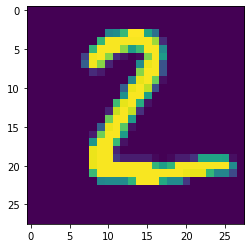

In [2]:
import matplotlib.pyplot as plt
import numpy as np

index= 1
print ("Making prediction for the image x_test["+str(index)+"]..")
imgplot = plt.imshow(x_test[index])
#model= tf.keras.models.load_model("model.h5")
predictions = model.predict(x_test)
predicted_y=np.argmax(predictions[index])
print ("the value in the image: "+ str(predicted_y))
print ("\n")
print (predictions[index])
fp32=predictions[index]

# Convert the model to tflite


1.   Configure TFLiteConverter with loading the model from file
2.   Convert the model
3.   Save the model with .tflite


In [3]:
tflite_converter = tf.lite.TFLiteConverter.from_keras_model_file("model.h5")
tflite_model = tflite_converter.convert()
open("tf_lite_model.tflite", "wb").write(tflite_model)

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Use `tf.compat.v1.graph_util.convert_variables_to_constants`
Instructions for updating:
Use `tf.compat.v1.graph_util.extract_sub_graph`
INFO:tensorflow:Froze 4 variables.
INFO:tensorflow:Converted 4 variables to const ops.


408224

#  Perform *inference* with tflite model


1.   Load TFLite model and allocate tensors
2.   Get input and output tensors
3.   Test model on random input data.
4.   The function `get_tensor()` returns a copy of the tensor data. Use `tensor()` in order to get a pointer to the tensor.


[[1.4405554e-08 2.7828739e-05 9.9989760e-01 7.3967691e-05 1.2786027e-12
  9.9027147e-08 4.6167990e-08 5.5685903e-13 5.1189323e-07 4.1179888e-13]]
the value in the image: 2


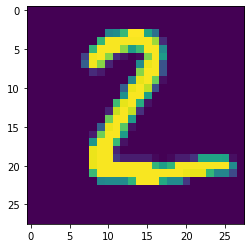

In [4]:
import numpy as np
import tensorflow as tf

# Load TFLite model and allocate tensors.
interpreter = tf.lite.Interpreter(model_path="tf_lite_model.tflite")
interpreter.allocate_tensors()

# Get input and output tensors.
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

# Test model on random input data.
#index=1
input_shape = input_details[0]['shape']
input_data = np.array (x_test[index:index+1:1], dtype=np.float32)

#input_data = np.array(np.random.random_sample(input_shape), dtype=np.float32)
#interpreter.set_tensor(input_details[0]['index'], input_data)
interpreter.set_tensor(input_details[0]['index'], input_data)
interpreter.invoke()

# The function `get_tensor()` returns a copy of the tensor data.
# Use `tensor()` in order to get a pointer to the tensor.
output_data = interpreter.get_tensor(output_details[0]['index'])
print(output_data)

predicted_yy=np.argmax(output_data)
print ("the value in the image: "+ str(predicted_yy))

imgplot = plt.imshow(x_test[index])

# Conversion 1: Hybrid/Weight quantization

*   Quantizes only the weights from floating point to 8-bits of precision
*   At inference, weights are converted from 8-bits of precision to floating point and computed using floating-point kernels. This conversion is done once and cached to reduce latency
*   To further improve latency, hybrid operators dynamically quantize activations to 8-bits and perform computations with 8-bit weights and activations. This optimization provides latencies close to fully fixed-point inference. However, the outputs are still stored using floating point, so that the speedup with hybrid ops is less than a full fixed-point computation

In [5]:
converter = tf.lite.TFLiteConverter.from_keras_model_file("model.h5")
converter.optimizations = [tf.lite.Optimize.OPTIMIZE_FOR_SIZE]
tflite_quant_model = converter.convert()

open("tf_lite_model_quant.tflite", "wb").write(tflite_quant_model)

INFO:tensorflow:Froze 4 variables.
INFO:tensorflow:Converted 4 variables to const ops.


103416

[[1.8473980e-08 2.8176941e-05 9.9988675e-01 8.4316132e-05 1.3789868e-12
  1.0216443e-07 4.8874139e-08 6.1580656e-13 5.9410428e-07 4.5621064e-13]]
the value in the image: 2


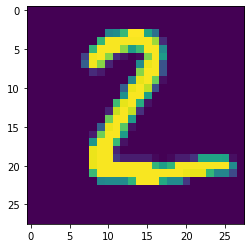

In [6]:
import numpy as np
import tensorflow as tf

# Load TFLite model and allocate tensors.
interpreter = tf.lite.Interpreter(model_path="tf_lite_model_quant.tflite")
interpreter.allocate_tensors()

# Get input and output tensors.
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

# Test model on random input data.
#index=1
input_shape = input_details[0]['shape']
input_data = np.array (x_test[index:index+1:1], dtype=np.float32)

#input_data = np.array(np.random.random_sample(input_shape), dtype=np.float32)
#interpreter.set_tensor(input_details[0]['index'], input_data)
interpreter.set_tensor(input_details[0]['index'], input_data)
interpreter.invoke()

# The function `get_tensor()` returns a copy of the tensor data.
# Use `tensor()` in order to get a pointer to the tensor.
output_data = interpreter.get_tensor(output_details[0]['index'])
print(output_data)
fp08=output_data

predicted_yy=np.argmax(output_data)
print ("the value in the image: "+ str(predicted_yy))

imgplot = plt.imshow(x_test[index])

## Results

In [7]:
print (fp32)

[1.4405554e-08 2.7828713e-05 9.9989760e-01 7.3967836e-05 1.2786027e-12
 9.9027147e-08 4.6167990e-08 5.5685903e-13 5.1189477e-07 4.1179972e-13]


In [8]:
fp8=fp08.ravel()
print (fp8)

[1.8473980e-08 2.8176941e-05 9.9988675e-01 8.4316132e-05 1.3789868e-12
 1.0216443e-07 4.8874139e-08 6.1580656e-13 5.9410428e-07 4.5621064e-13]


In [9]:
diff=fp32-fp8
print (diff)

[-4.0684256e-09 -3.4822733e-07  1.0848045e-05 -1.0348296e-05
 -1.0038411e-13 -3.1372807e-09 -2.7061482e-09 -5.8947530e-14
 -8.2209510e-08 -4.4410927e-14]


In [10]:
#print (format(9.9938798e-01 , 'f'))

diff_f = ['{:f}'.format(item) for item in diff]
diff_f

['-0.000000',
 '-0.000000',
 '0.000011',
 '-0.000010',
 '-0.000000',
 '-0.000000',
 '-0.000000',
 '-0.000000',
 '-0.000000',
 '-0.000000']

In [11]:
print ("Std: " +str(np.std(diff)) )
print ("Var: "+ str(np.var(diff)) )

Std: 4.74231e-06
Var: 2.2489503e-11


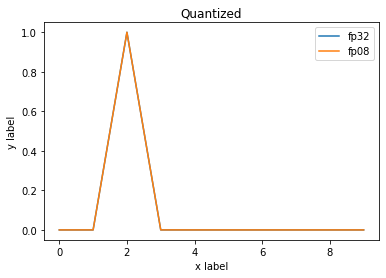

In [12]:

x = np.linspace(0, 9, 10)
plt.plot(x, fp32, label='fp32')
plt.plot(x, fp8, label='fp08')


plt.xlabel('x label')
plt.ylabel('y label')

plt.title("Quantized")

plt.legend()

plt.show()

# References:
[1]  https://www.tensorflow.org/lite/performance/post_training_quantization